# Hough Transform
The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maxima in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough transform.

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.transform import hough_line, hough_line_peaks
import cv2
%matplotlib inline

In [2]:
def imshow(img):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    plt.show()
def __norm(im):
    im = np.array(im).astype('float32')
    im = (im-np.min(im))*255/(np.max(im)-np.min(im))
    return im.astype('uint8')

## Open Image
UFPR.jpg <br>
lines.png <br>
sudoku.jpg

(550, 825)


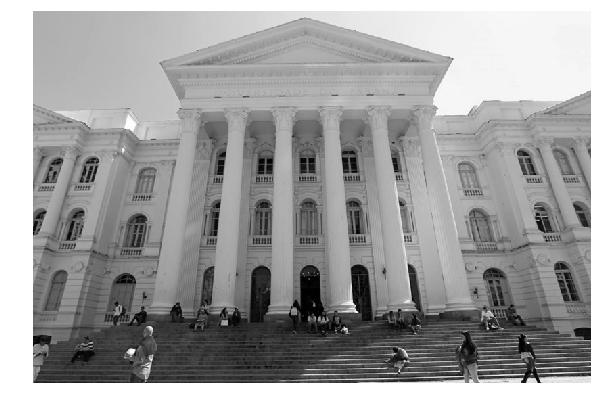

In [3]:
im_gray = cv2.imread('imgs/UFPR.jpg',cv2.IMREAD_GRAYSCALE)
print(im_gray.shape)
imshow(im_gray)

## Binary Image

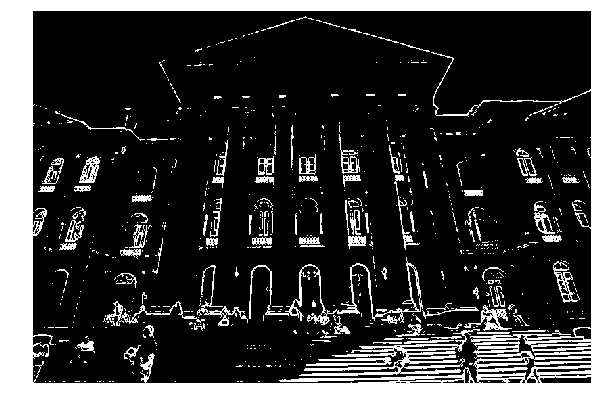

In [5]:
def bin_im1(im_gray, _disk = 1):
    im_grad = gradient(im_gray, disk(_disk))
    # Otsu's thresholding 
    ret3,im_bin = cv2.threshold(im_grad,0,255,cv2.THRESH_OTSU)
    return im_bin

im_bin = bin_im1(im_gray)
imshow(im_bin)

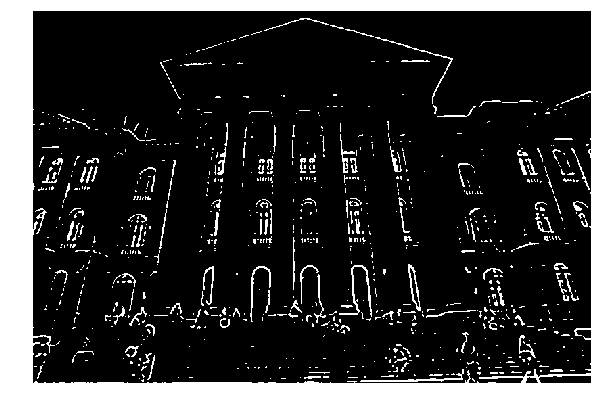

In [4]:
def bin_im2(im_gray):
    
    im_gray = cv2.medianBlur(im_gray, 5)
    
    im_grad = cv2.Laplacian(im_gray,cv2.CV_32F,ksize=7)
    im_grad[im_grad<0] = 0
    im_grad = __norm(im_grad)

    # Otsu's thresholding 
    ret3,im_bin = cv2.threshold(im_grad,0,255,cv2.THRESH_OTSU)
    
    return im_bin

im_bin = bin_im2(im_gray)
imshow(im_bin)

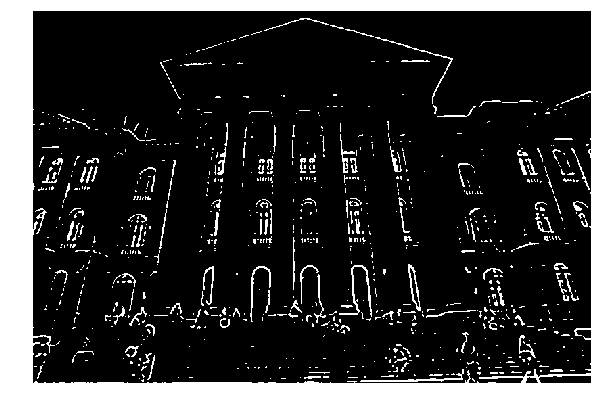

In [5]:
imshow(im_bin)

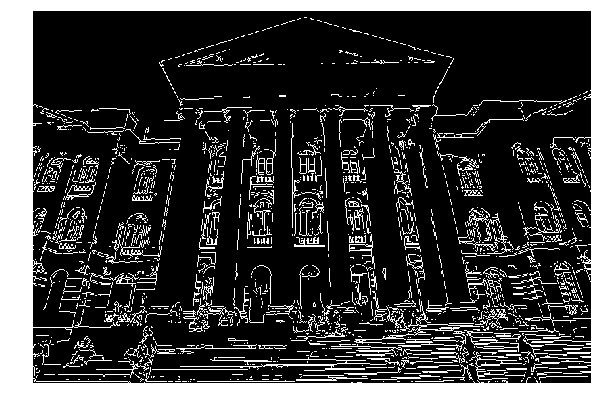

In [6]:
def bin_im3(im_gray,thresholds = (50,200)):
    im_bin = cv2.Canny(im_gray,thresholds[0],thresholds[1])
    return im_bin

im_bin = bin_im3(im_gray)
imshow(im_bin)

## Hough Transform
$r = xsin(\theta)+ycos(\theta)$ <br>
$r \in \left[-\sqrt{M^2+N^2},\sqrt{M^2+N^2}\right]$<br>
$\theta \in \left[ -\dfrac{\pi}{2},\dfrac{\pi}{2}\right]$ <br>

In [6]:
y_max, x_max = im_bin.shape

r_steps = 2000
r_max = np.sqrt(y_max**2+x_max**2)
r_min = -r_max
#r_steps = np.ceil(r_max-r_min).astype('int')
r_step = (r_max-r_min)/(r_steps-1)
r_list = np.arange(r_min,r_max+r_step,r_step)
if r_list.shape[0]!=r_steps:
    r_list = r_list[:-1]

o_steps = 2000
o_max = -np.pi/2
o_min = -o_max
o_step = (o_max-o_min)/(o_steps-1)
o_list = np.arange(o_min,o_max+o_step,o_step)
if o_list.shape[0]!=o_steps:
    o_list = o_list[:-1]

r_steps,o_list.shape

(2000, (2000,))

In [8]:
%%time
im_hough = np.zeros((r_steps,o_steps))
for y in range(im_bin.shape[0]):
    for x in range(im_bin.shape[1]):
        if im_bin[y,x]:
            r_o_list = x*np.cos(o_list)+y*np.sin(o_list)
            r = np.round((r_o_list-r_min)/r_step).astype('int')
            im_hough[r,range(o_steps)]+=1
            

CPU times: user 31.4 s, sys: 18.1 ms, total: 31.5 s
Wall time: 31.5 s


In [7]:
print(im_hough.shape)
imshow(im_hough)

NameError: name 'im_hough' is not defined

## Plot lines

In [8]:
def plot_lines(im_gray,dists,angles,linewidth=0.7):
    y_max, x_max = im_gray.shape
    #dists =np.around(dists+y_max)
    #x1s = 0
    y1s = np.around(dists/np.cos(angles))  
    #x2s = x_max
    y2s = np.around((dists-x_max*np.sin(angles))/np.cos(angles))
    
    #plot img
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(im_gray, cmap='gray')
    
    #plot lines
    for y1,y2 in zip(y1s,y2s):
        #plt.plot(x,y)
        #plt.plot((0, x_max), (y1, y2), 'r',linewidth=linewidth)
        plt.plot( (y2, y1),(x_max,0), 'r',linewidth=linewidth)
    # [xmin, xmax, ymin, ymax] ivert y for image
    plt.axis((0,x_max,y_max,0))
    
    plt.show()

In [9]:
_, angles, dists = hough_line_peaks(im_hough, o_list, r_list)
plot_lines(im_bin,dists,angles)

NameError: name 'im_hough' is not defined

## Skimage

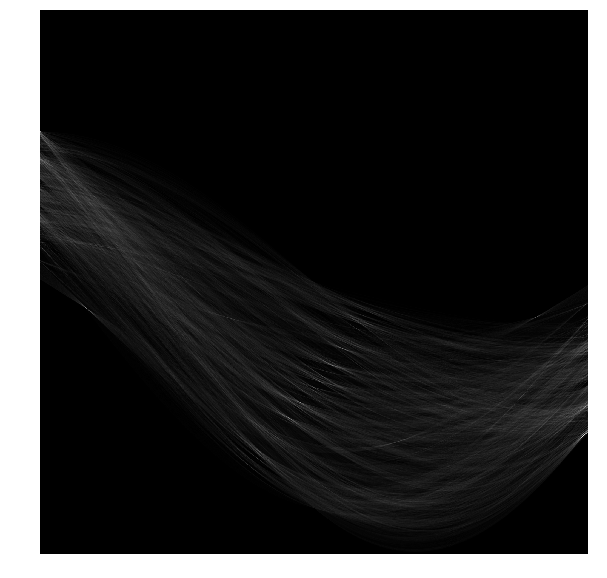

CPU times: user 690 ms, sys: 219 ms, total: 909 ms
Wall time: 697 ms


In [10]:
%%time
h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/2000))
imshow(h)

Peaks or Lines: 8


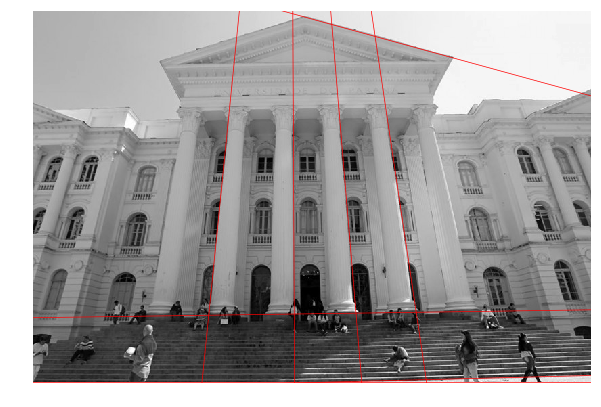

In [11]:
_, angles, dists = hough_line_peaks(h, theta, d)
print('Peaks or Lines:',len(angles))
plot_lines(im_gray,dists,angles)

## Find Lines 1
Simple Threshold <br>
Threshold = $\alpha(max-min)$

In [54]:
def hough_peaks1(im_hough, o_list, r_list, alpha=0.5):
    
    #mask create
    threshold = (im_hough.max()-im_hough.min())*alpha
    mask_peaks = im_hough>threshold
    
    #find all lines
    angles = list()
    dists = list()
    peaks = list()
    for r in range(mask_peaks.shape[0]):
        for o in range(mask_peaks.shape[1]):
            if mask_peaks[r][o]:
                angles.append(o_list[o])
                dists.append(r_list[r])
                peaks.append(im_hough[r][o])
    
    #to numpy
    angles = np.array(angles)
    dists = np.array(dists) 
    peaks = np.array(peaks) 
    
    print('Threshold:',threshold,'Peaks or Lines:',len(peaks))
    
    return peaks,angles,dists

Threshold: 588.5 Peaks or Lines: 343


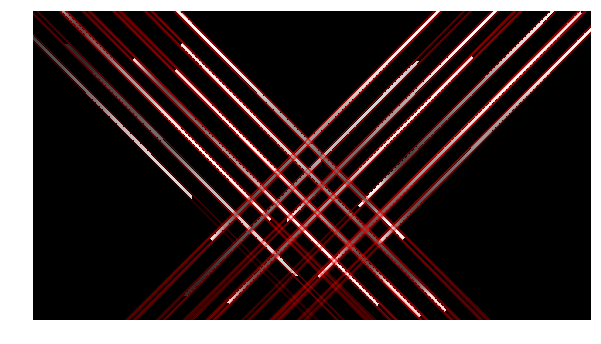

CPU times: user 1.9 s, sys: 176 ms, total: 2.08 s
Wall time: 1.85 s


In [55]:
%%time
_,angles,dists = hough_peaks1(im_hough, o_list, r_list)
plot_lines(im_gray,dists,angles,0.1)

## Find Lines 2
Simple Threshold <br>
$\downarrow$  <br>
Graph by Euclidean Distances of the peaks <br>
$\downarrow$  <br>
Component Connection <br>
$\downarrow$  <br>
Lines by weighted arithmetic mean 

In [56]:
alpha = 0.4 # Threshold [0,1[
beta = 2 #maximum distance of connected peaks (in pixels)

In [57]:
peaks,angles,dists = hough_peaks1(im_hough, o_list, r_list,alpha=alpha)

Threshold: 470.8 Peaks or Lines: 640


### My codes:

In [58]:
from collections import deque

#### Create Graph by Euclidean Distances
adjacency lists

In [59]:
%%time

adjacency_lists = list()

for i in range(len(peaks)):
    #Euclidean distances between point i and all points before i
    x1 = angles[i]
    x2 = angles#[i+1:]
    y1 = dists[i]
    y2 = dists#[i+1:]
    euclid_dist = (x2-x1)**2+(y2-y1)**2
    # very slow function
    #euclid_dist = euclidean_distances([[x1,y1]],zip(x2,y2))[0]
    
    #find edges
    edges = euclid_dist<(beta**2)
    edges = np.arange(edges.shape[0])[edges]
    #edges += i+1
    #edges = [(i,j) for j in edges]

    #save edges
    adjacency_lists.append(edges.astype('int32'))
    #edges_list = np.append(edges_list,np.array(edges))
    #edges_list += list(edges)

    #print
    if i%10000==0:
        print(i,'/',len(peaks))

print("to numpy ...")
adjacency_lists = np.array(adjacency_lists)
print(adjacency_lists.shape)

0 / 640
to numpy ...
(640,)
CPU times: user 13.7 ms, sys: 125 µs, total: 13.8 ms
Wall time: 13.4 ms


__Component Connection:__

In [60]:
%%time

visited = np.zeros(len(peaks))
n_class = 0

for v in range(len(peaks)):
    if visited[v]:
        continue
    
    #new class or component
    n_class += 1
    visited[v] = n_class
    
    #stack of vertices to look
    stack = deque()
    stack.append(v)
    
    while stack:
        #new vertice
        v = stack.pop()
        
        #add all neighbors not visited
        for neighbor in adjacency_lists[v]:
            
            if not visited[neighbor]:
                stack.append(neighbor)
                visited[neighbor] = n_class
                
print(n_class,'class')

18 class
CPU times: user 5.88 ms, sys: 8 µs, total: 5.89 ms
Wall time: 5.52 ms


__Creating Lines:__
weighted arithmetic mean 

In [61]:
avg_angles = list()
avg_dists = list()
avg_peaks = list()

for c in range(n_class):
    
    #class mask
    mask = visited==(c+1)
    print(mask.sum(), 'peaks')
    
    #component connection points
    cc_angles = angles[mask]
    cc_dists = dists[mask]
    cc_peaks = peaks[mask]
    
    #weighted arithmetic mean 
    angle = np.average(cc_angles, weights=cc_peaks)
    dist = np.average(cc_dists, weights=cc_peaks)
    peak = np.average(cc_peaks)
    
    #save
    avg_angles.append(angle)
    avg_dists.append(dist)
    avg_peaks.append(peak)

#to numpy
avg_angles = np.array(avg_angles)
avg_dists = np.array(avg_dists)
avg_peaks = np.array(avg_peaks)

12 peaks
11 peaks
30 peaks
50 peaks
47 peaks
66 peaks
53 peaks
45 peaks
24 peaks
25 peaks
16 peaks
16 peaks
23 peaks
22 peaks
60 peaks
34 peaks
68 peaks
38 peaks


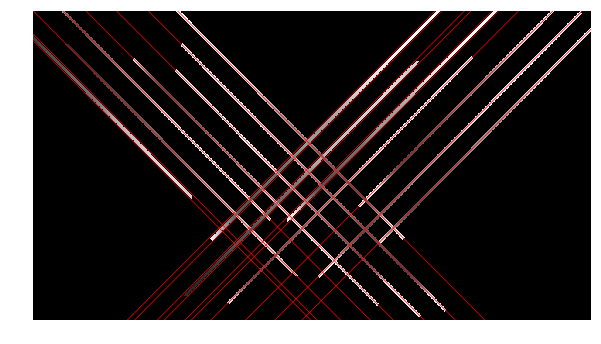

In [62]:
plot_lines(im_gray,avg_dists,avg_angles)

### With Libraries

In [63]:
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx

__Euclidean Distance Matrix:__

In [64]:
pts = list(zip(angles,dists))
euclidean_matrix = euclidean_distances(pts)

__Create Graph:__

In [65]:
adj_matrix = euclidean_matrix<beta
G = nx.from_numpy_matrix(adj_matrix)

CPU times: user 3.64 s, sys: 151 ms, total: 3.79 s
Wall time: 3.64 s


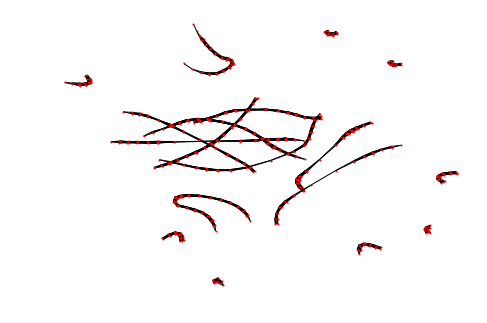

In [66]:
%%time
nx.draw(G,node_size=1)

__Connected Components:__

In [67]:
connected_components = nx.connected_components(G)
connected_components = sorted(nx.connected_components(G), key = len, reverse=True)
len(connected_components)

18

__Creating Lines:__ <br>
weighted arithmetic mean 

In [68]:
avg_angles = list()
avg_dists = list()
avg_peaks = list()
for cc in connected_components:
    
    #points in components
    cc = list(cc)
    cc_angles = angles[cc]
    cc_dists = dists[cc]
    cc_peaks = peaks[cc]
    
    #weighted arithmetic mean 
    angle = np.average(cc_angles, weights=cc_peaks)
    dist = np.average(cc_dists, weights=cc_peaks)
    peak = np.average(cc_peaks)
    
    #save
    avg_angles.append(angle)
    avg_dists.append(dist)
    avg_peaks.append(peak)

#to numpy
avg_angles = np.array(avg_angles)
avg_dists = np.array(avg_dists)
avg_peaks = np.array(avg_peaks)

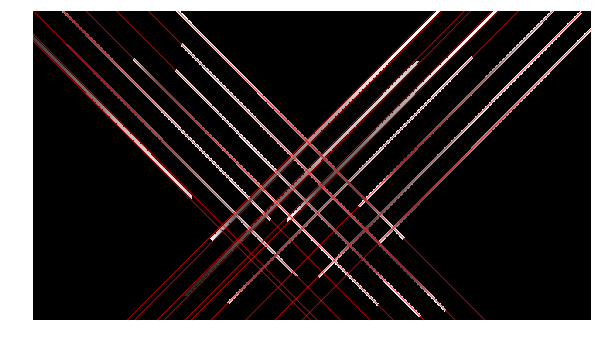

In [69]:
plot_lines(im_gray,avg_dists,avg_angles)

## Find Lines 3

In [70]:
def func_conv(im_hough, function, ksize=(5,5), strides=(1,1), *args):
    
    #only odd numbers
    if not (ksize[0]%2 and ksize[1]%2):
        return
    
    #sizes
    border = np.array([int(ksize[0]/2),int(ksize[1]/2)])
    h_size = im_hough.shape
    
    #border image
    im_border = np.zeros(h_size+2*border)
    im_border[border[0]:h_size[0]+border[0],border[1]:h_size[1]+border[1]] = im_hough
    
    #convolution function
    im_out = list()
    for i in range(0,h_size[0],strides[0]):
        line = list()
        for j in range(0,h_size[1],strides[1]):
            
            im_cut = im_border[i:i+ksize[0],j:j+ksize[1]]
            pixel = function(im_cut,*args)
            
            line.append(pixel)
        im_out.append(line)
    
    #return 
    im_out = np.array(im_out).astype('float32')
    
    return im_out

### 3.1 -  Kernel 1 (Averaging)

$K = \dfrac{1}{25} \begin{bmatrix} 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \\ 1 & 1 & 1 & 1 & 1 \end{bmatrix}$

In [71]:
def func_kernel1(im):
    
    n = im.shape[0]*im.shape[1]
    kernel = np.ones(im.shape)
    
    return np.sum(im*kernel)/n

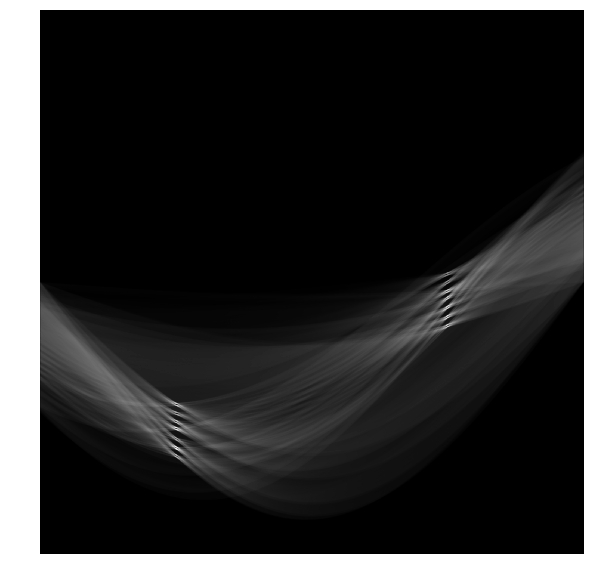

CPU times: user 43.1 s, sys: 233 ms, total: 43.4 s
Wall time: 43.2 s


In [72]:
%%time
im_kernel1 = func_conv(im_hough,func_kernel1)
imshow(im_kernel1)

Threshold: 238.44000244140625 Peaks or Lines: 5299


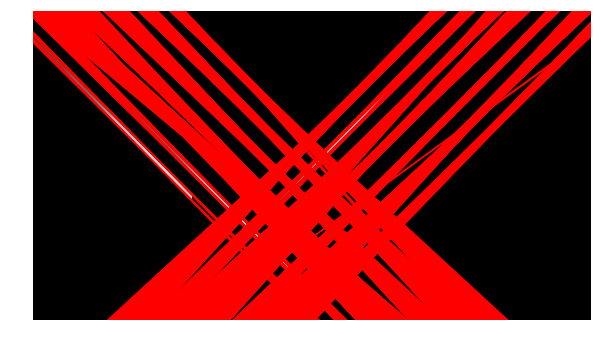

CPU times: user 21.4 s, sys: 223 ms, total: 21.6 s
Wall time: 21.4 s


In [73]:
%%time
#Simple Threshold 
_,angles,dists = hough_peaks1(im_kernel1, o_list, r_list)
plot_lines(im_gray,dists,angles)

### 3.2 -  Kernel 2 (Gaussian)

$A = \begin{bmatrix}0.0625\\0.25\\0.375\\0.25\\0.0625 \end{bmatrix} \ \ \ \ \
K = A.A^T = \begin{bmatrix}  0.0039&0.0156&0.0234&0.0156&0.0039 \\ 0.0156&0.0625&0.0937&0.0625&0.0156 \\ 0.0234&0.0937&0.1406&0.0937&0.0234 \\ 0.0156&0.0625&0.0937&0.0625&0.0156 \\ 0.0039&0.0156&0.0234&0.0156&0.0039  \end{bmatrix}$

In [74]:
def func_kernel2(im,sigma=-1):
    
    #kernel 1D
    gaus1D_1 = cv2.getGaussianKernel(im.shape[0],sigma)
    gaus1D_2 = cv2.getGaussianKernel(im.shape[1],sigma)
    
    #kernel 2D
    gaus2D = np.dot(gaus1D_1,gaus1D_2.T)

    return np.sum(im*gaus2D)

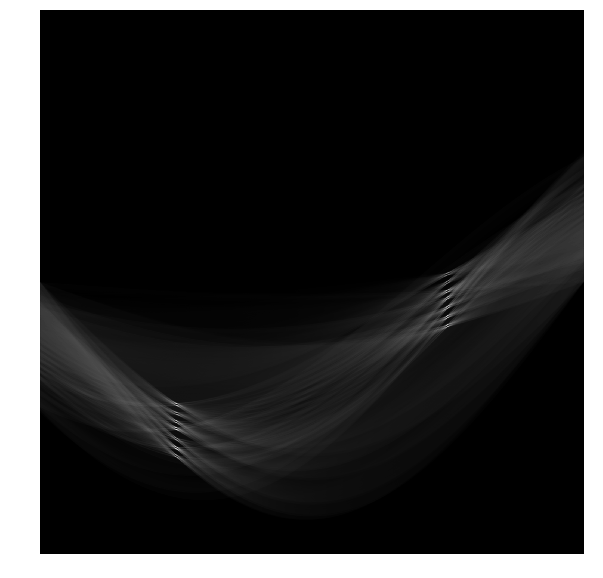

CPU times: user 57.8 s, sys: 196 ms, total: 58 s
Wall time: 57.9 s


In [75]:
%%time
im_kernel2 = func_conv(im_hough,func_kernel2)
imshow(im_kernel2)

Threshold: 346.91796875 Peaks or Lines: 1114


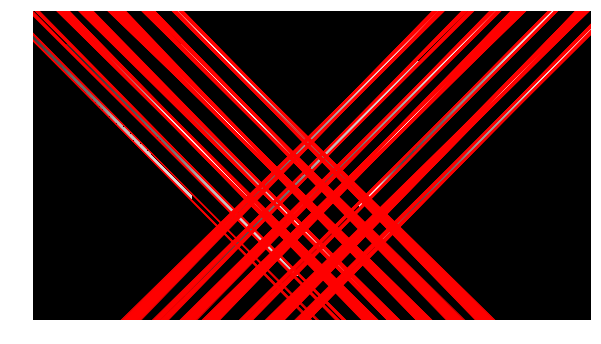

CPU times: user 5.46 s, sys: 136 ms, total: 5.6 s
Wall time: 5.55 s


In [76]:
%%time
#Simple Threshold 
_,angles,dists = hough_peaks1(im_kernel2, o_list, r_list)
plot_lines(im_gray,dists,angles)

### 3.3 -  Kernel 3 (Custom)

In [77]:
def func_kernel3(im,kernel):
    out = np.sum(im*kernel)
    return out

In [78]:
kernel = [[ 0, 0, 0, 0, 0],
          [ 0, 0, 0, 0, 0],
          [ 1, 1, 1, 1, 1],
          [ 0, 0, 0, 0, 0],
          [ 0, 0, 0, 0, 0]]
kernel = np.array(kernel)/np.sum(kernel)

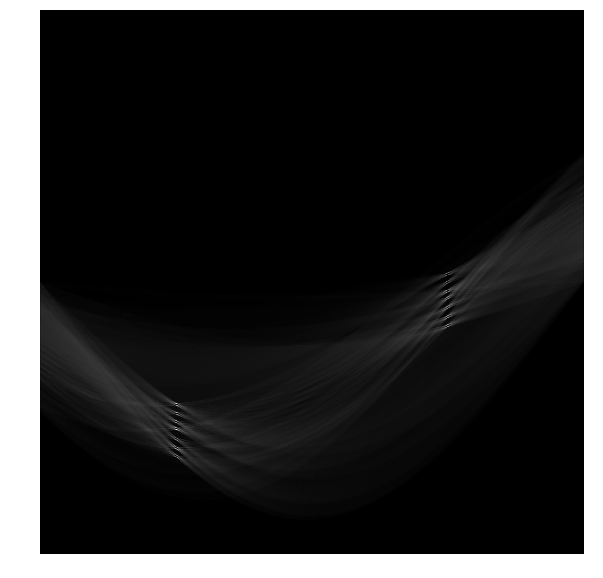

CPU times: user 29.9 s, sys: 252 ms, total: 30.1 s
Wall time: 29.9 s


In [79]:
%%time
im_kernel3 = func_conv(im_hough,func_kernel3,kernel.shape,(1,1),kernel)
imshow(im_kernel3)

Threshold: 490.70001220703125 Peaks or Lines: 403


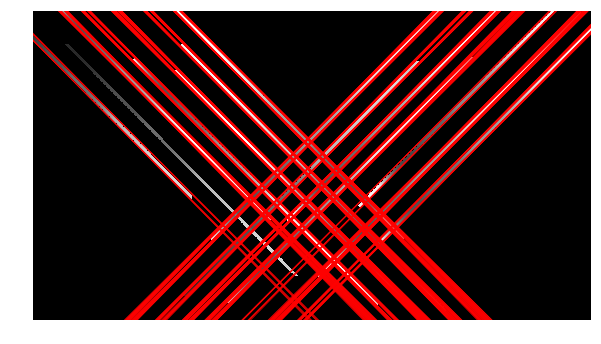

CPU times: user 2.46 s, sys: 160 ms, total: 2.62 s
Wall time: 2.4 s


In [80]:
%%time
#Simple Threshold 
_,angles,dists = hough_peaks1(im_kernel3, o_list, r_list)
plot_lines(im_gray,dists,angles)